<h1> <b> <div style='padding:25px;background-color:#9B2335;color:white;border-radius:4px;font-size:100%;text-align: center'>Singapore  Resale Flat Prices Prediction<br> </div></h1>

<h2> <p style="color:Khaki;"> Importing required libraries</p></h2>

In [2]:
import pandas as pd
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import pearsonr,kstest, norm, skew,kurtosis, boxcox
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import pickle

sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

color_good = '\033[32m'   # Dark Green for near-zero skew
color_okay = '\033[92m'   # Light Green for slightly positive or slightly negative skew
color_bad = '\033[91m'    # Maroon for significant skew
color_neutral = '\033[0m' # Reset color

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
import pickle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score,root_mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder
import time
from colorama import Fore, Style
from xgboost import XGBRegressor, cv, DMatrix


color_positive = Fore.GREEN
reset_color = Style.RESET_ALL


---
title: "Model Building - Before Outlier"
author: "Santhoh Kumar"
date: last-modified
format: 
  html:
    theme: darkly
    fontsize: 1.1em
    max-width: 2800px
    fontcolor: "#ffffff"
    code-fold: true
    code-tools: true
    code-block-bg: true
    code-block-border-left: "#31BAE9"
    toc: true
    toc-depth: 4
    toc-expand: 4
    toc-location: body
    number-sections: true
    number-depth: 3
jupyter: python3
---


## <span style="color:Khaki;">Reading Transformed Dataset

In [3]:
df1=pd.read_feather('data_trans.feather')

In [4]:
df1.sample(4)

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,floors,floor_no,year,full_address,price_per_sqm,remaining_lease_year,resale_price_boxcox,floor_area_boxcox
39506,11,Jurong East,Executive,140.0000,Apartment,1998,811000.0000,3,18,2018,286C Toh Guan Rd Jurong East,5792.8571,79,887.8488,12.8456
14575,3,Ang Mo Kio,1 Room,31.0000,Improved,1977,9600.0000,3,9,1991,309 Ang Mo Kio Ave 1 Ang Mo Kio,309.6774,85,124.9145,6.6029
23122,4,Sengkang,3 Room,68.0000,Model A,2013,365000.0000,3,9,2016,210C Compassvale Lane Sengkang,5367.6471,96,624.8976,9.4462
276040,11,Sengkang,4 Room,85.0000,Model A2,2000,287000.0000,3,9,2008,185D Rivervale Cres Sengkang,3376.4706,91,562.1366,10.4075


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 927465 entries, 0 to 181261
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   month                 927465 non-null  category
 1   town                  927465 non-null  category
 2   flat_type             927465 non-null  category
 3   floor_area_sqm        927465 non-null  float32 
 4   flat_model            927465 non-null  category
 5   lease_commence_date   927465 non-null  category
 6   resale_price          927465 non-null  float64 
 7   floors                927465 non-null  category
 8   floor_no              927465 non-null  int8    
 9   year                  927465 non-null  category
 10  full_address          927465 non-null  category
 11  price_per_sqm         927465 non-null  float64 
 12  remaining_lease_year  927465 non-null  category
 13  resale_price_boxcox   927465 non-null  float64 
 14  floor_area_boxcox     927465 non-null  fl

## <span style="color:Khaki;"> Encoding Categorical Features:</span> 

In [6]:
town_en = df1.groupby('town',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
town_en_list = dict(zip(town_en['town'], town_en['resale_price_boxcox'].astype(int)))
print(town_en_list)

{'Lim Chu Kang': 1, 'Queenstown': 2, 'Ang Mo Kio': 3, 'Clementi': 4, 'Geylang': 5, 'Bedok': 6, 'Bukit Batok': 7, 'Yishun': 8, 'Toa Payoh': 9, 'Jurong East': 10, 'Central Area': 11, 'Jurong West': 12, 'Kallang/Whampoa': 13, 'Woodlands': 14, 'Hougang': 15, 'Serangoon': 16, 'Marine Parade': 17, 'Bukit Merah': 18, 'Bukit Panjang': 19, 'Tampines': 20, 'Choa Chu Kang': 21, 'Sembawang': 22, 'Pasir Ris': 23, 'Bishan': 24, 'Bukit Timah': 25, 'Sengkang': 26, 'Punggol': 27}


In [7]:
df1['town_en'] = df1['town'].map(town_en_list)
df1['town_en'] = df1['town_en'].astype('int8')

In [8]:
year_en = df1.groupby('year',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
year_en_list = dict(zip(year_en['year'], year_en['resale_price_boxcox'].astype(int)))
print(year_en_list)

{1990: 1, 1991: 2, 1992: 3, 1993: 4, 1994: 5, 1995: 6, 2002: 7, 2003: 8, 2004: 9, 2001: 10, 2005: 11, 2006: 12, 1999: 13, 2000: 14, 1998: 15, 1996: 16, 2007: 17, 1997: 18, 2008: 19, 2009: 20, 2010: 21, 2019: 22, 2015: 23, 2018: 24, 2011: 25, 2016: 26, 2017: 27, 2014: 28, 2020: 29, 2012: 30, 2013: 31, 2021: 32, 2022: 33, 2023: 34, 2024: 35}


In [9]:
df1['year_en'] = df1['year'].map(year_en_list)
df1['year_en'] = df1['year_en'].astype('int8')

In [10]:
flat_type_en = df1.groupby('flat_type',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
flat_type_en_list = dict(zip(flat_type_en['flat_type'], flat_type_en['resale_price_boxcox'].astype(int)))
print(flat_type_en_list)

{'1 Room': 1, '2 Room': 2, '3 Room': 3, '4 Room': 4, '5 Room': 5, 'Executive': 6, 'Multi Generation': 7}


In [11]:
df1['flat_type_en'] = df1['flat_type'].map(flat_type_en_list)
df1['flat_type_en'] = df1['flat_type_en'].astype('int8')

In [12]:
flat_model_en = df1.groupby('flat_model',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
flat_model_en_list = dict(zip(flat_model_en['flat_model'], flat_model_en['resale_price_boxcox'].astype(int)))
print(flat_model_en_list)

{'New Generation': 1, 'Standard': 2, 'Simplified': 3, 'Model A2': 4, '2-Room': 5, 'Model A': 6, 'Improved': 7, 'Improved-Maisonette': 8, 'Model A-Maisonette': 9, 'Premium Apartment': 10, 'Adjoined Flat': 11, 'Maisonette': 12, 'Apartment': 13, 'Terrace': 14, 'Multi Generation': 15, 'Premium Maisonette': 16, '3Gen': 17, 'Dbss': 18, 'Premium Apartment Loft': 19, 'Type S1': 20, 'Type S2': 21}


In [13]:
df1['flat_model_en'] = df1['flat_model'].map(flat_model_en_list)
df1['flat_model_en'] = df1['flat_model_en'].astype('int8')

In [14]:
lease_commence_en = df1.groupby('lease_commence_date',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
lease_commence_en_list = dict(zip(lease_commence_en['lease_commence_date'], lease_commence_en['resale_price_boxcox'].astype(int)))
print(lease_commence_en_list)

{1969: 1, 1971: 2, 1967: 3, 1968: 4, 1973: 5, 1970: 6, 1972: 7, 1974: 8, 1977: 9, 1980: 10, 1983: 11, 1975: 12, 1981: 13, 1976: 14, 1978: 15, 1979: 16, 1966: 17, 1982: 18, 1985: 19, 1984: 20, 1986: 21, 1987: 22, 1988: 23, 1990: 24, 1989: 25, 1991: 26, 1997: 27, 1998: 28, 1996: 29, 1999: 30, 1994: 31, 1993: 32, 2000: 33, 1995: 34, 1992: 35, 2001: 36, 2002: 37, 2003: 38, 2004: 39, 2012: 40, 2014: 41, 2015: 42, 2005: 43, 2007: 44, 2010: 45, 2013: 46, 2008: 47, 2016: 48, 2009: 49, 2017: 50, 2018: 51, 2019: 52, 2006: 53, 2020: 54, 2011: 55}


In [15]:
df1['lease_commence_en'] = df1['lease_commence_date'].map(lease_commence_en_list)
df1['lease_commence_en'] = df1['lease_commence_en'].astype('int8')

In [16]:
floors_en = df1.groupby('floors',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
floors_en_list = dict(zip(floors_en['floors'], floors_en['resale_price_boxcox'].astype(int)))
print(floors_en_list)

{3: 1, 5: 2}


In [17]:
df1['floors_en'] = df1['floors'].map(floors_en_list)
df1['floors_en'] = df1['floors_en'].astype('int8')

In [18]:
floor_no_en = df1.groupby('floor_no',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
floor_no_en_list = dict(zip(floor_no_en['floor_no'], floor_no_en['resale_price_boxcox'].astype(int)))
print(floor_no_en_list)

{3: 1, 6: 2, 9: 3, 12: 4, 15: 5, 5: 6, 18: 7, 10: 8, 21: 9, 24: 10, 20: 11, 27: 12, 25: 13, 35: 14, 40: 15, 30: 16, 33: 17, 36: 18, 39: 19, 42: 20, 45: 21, 48: 22, 51: 23}


In [19]:
df1['floor_no_en'] = df1['floor_no'].map(floor_no_en_list)
df1['floor_no_en'] = df1['floor_no_en'].astype('int8')

In [20]:
remaining_lease_year_en = df1.groupby('remaining_lease_year',observed=False)['resale_price_boxcox'].median().rank(method='first').reset_index().sort_values('resale_price_boxcox')
remaining_lease_year_en_list = dict(zip(remaining_lease_year_en['remaining_lease_year'], remaining_lease_year_en['resale_price_boxcox'].astype(int)))
print(remaining_lease_year_en_list)

{81: 1, 82: 2, 83: 3, 80: 4, 79: 5, 84: 6, 78: 7, 85: 8, 77: 9, 76: 10, 86: 11, 75: 12, 87: 13, 88: 14, 48: 15, 74: 16, 89: 17, 49: 18, 90: 19, 47: 20, 72: 21, 73: 22, 71: 23, 45: 24, 46: 25, 70: 26, 91: 27, 44: 28, 43: 29, 50: 30, 69: 31, 92: 32, 93: 33, 68: 34, 41: 35, 42: 36, 51: 37, 67: 38, 96: 39, 52: 40, 58: 41, 66: 42, 94: 43, 59: 44, 95: 45, 57: 46, 100: 47, 65: 48, 101: 49, 53: 50, 56: 51, 64: 52, 54: 53, 55: 54, 98: 55, 60: 56, 63: 57, 62: 58, 61: 59, 97: 60, 99: 61}


In [21]:
df1['remaining_lease_year_en'] = df1['remaining_lease_year'].map(remaining_lease_year_en_list)
df1['remaining_lease_year_en'] = df1['remaining_lease_year_en'].astype('int8')

In [22]:
df1.columns

Index(['month', 'town', 'flat_type', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'resale_price', 'floors', 'floor_no', 'year',
       'full_address', 'price_per_sqm', 'remaining_lease_year',
       'resale_price_boxcox', 'floor_area_boxcox', 'town_en', 'year_en',
       'flat_type_en', 'flat_model_en', 'lease_commence_en', 'floors_en',
       'floor_no_en', 'remaining_lease_year_en'],
      dtype='object')

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 927465 entries, 0 to 181261
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   month                    927465 non-null  category
 1   town                     927465 non-null  category
 2   flat_type                927465 non-null  category
 3   floor_area_sqm           927465 non-null  float32 
 4   flat_model               927465 non-null  category
 5   lease_commence_date      927465 non-null  category
 6   resale_price             927465 non-null  float64 
 7   floors                   927465 non-null  category
 8   floor_no                 927465 non-null  int8    
 9   year                     927465 non-null  category
 10  full_address             927465 non-null  category
 11  price_per_sqm            927465 non-null  float64 
 12  remaining_lease_year     927465 non-null  category
 13  resale_price_boxcox      927465 non-null  float64

In [24]:
df1.sample(3)

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,floors,floor_no,year,...,resale_price_boxcox,floor_area_boxcox,town_en,year_en,flat_type_en,flat_model_en,lease_commence_en,floors_en,floor_no_en,remaining_lease_year_en
130163,4,Pasir Ris,Executive,145.0000,Apartment,1993,720000.0000,3,6,2022,...,842.5789,13.0334,23,33,6,13,32,1,2,26
21121,1,Sengkang,4 Room,90.0000,Premium Apartment,2006,575000.0000,3,9,2013,...,763.2320,10.6659,26,31,4,10,53,1,3,32
97830,9,Bedok,4 Room,91.0000,New Generation,1985,183000.0000,3,6,2002,...,461.0507,10.7165,6,7,4,1,19,1,2,2


## <p Style="color:Khaki;"> Feature Selection:

### <p Style="color:Aqua;"> Dropping Categorical Features & Unnecessary:

In [46]:
df2 = df1.drop(columns=['month', 'town', 'flat_type', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'resale_price', 'floors', 'floor_no', 'year',
       'full_address', 'price_per_sqm', 'remaining_lease_year',],axis=1).copy()

In [47]:
df2.columns

Index(['resale_price_boxcox', 'floor_area_boxcox', 'town_en', 'year_en',
       'flat_type_en', 'flat_model_en', 'lease_commence_en', 'floors_en',
       'floor_no_en', 'remaining_lease_year_en'],
      dtype='object')

### <p Style="color:Aqua;"> Correlation:

In [48]:
df2['location_specifics'] = df2['resale_price_boxcox'] *df2['town_en']
df2['floor_area_year'] = df2['resale_price_boxcox'] *df2['remaining_lease_year_en']
df2['age']=df2['year_en'] - df2['remaining_lease_year_en']

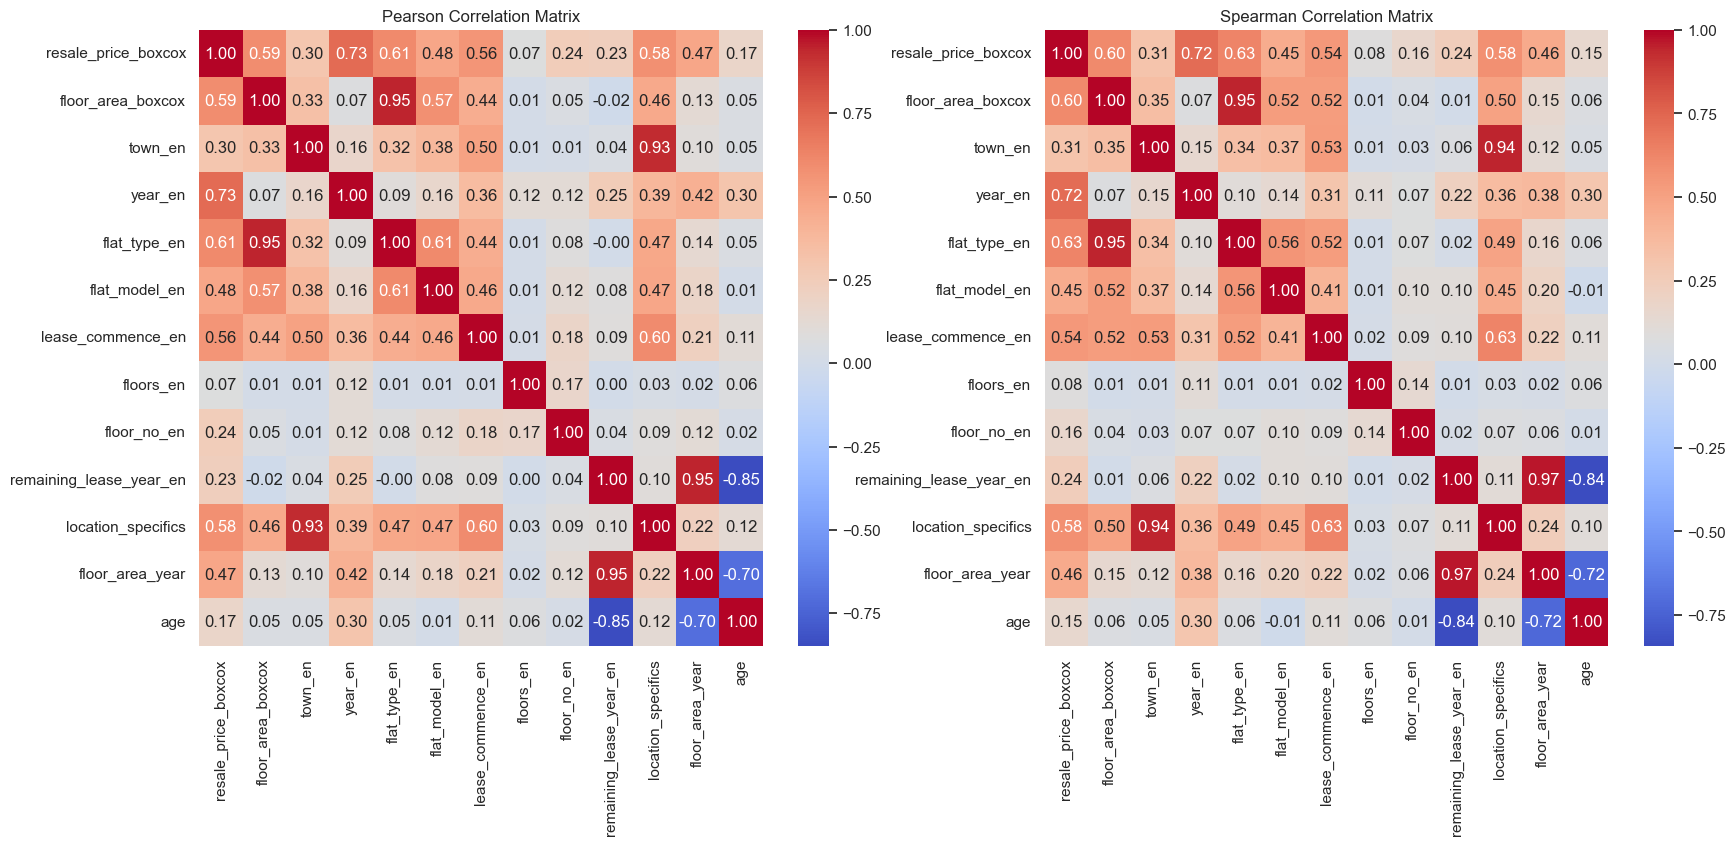

In [49]:
cor_col = df2.select_dtypes(include='number')
correlation_matrix_pear = cor_col.corr()
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.heatmap(correlation_matrix_pear,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('Pearson Correlation Matrix')


cor_col = df2.select_dtypes(include='number')
correlation_matrix = cor_col.corr(method='spearman')
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('Spearman Correlation Matrix')
plt.show()

In [50]:
target_corr = df2.select_dtypes(include='number').corr(method='spearman')['resale_price_boxcox'].abs().sort_values(ascending=False)[1:]
target_corr

year_en                   0.7226
flat_type_en              0.6297
floor_area_boxcox         0.6048
location_specifics        0.5788
lease_commence_en         0.5447
floor_area_year           0.4568
flat_model_en             0.4460
town_en                   0.3115
remaining_lease_year_en   0.2379
floor_no_en               0.1617
age                       0.1527
floors_en                 0.0792
Name: resale_price_boxcox, dtype: float64

## <span style="color:Khaki;"> Splitting train and test Data:</span> 

In [51]:
df2.columns

Index(['resale_price_boxcox', 'floor_area_boxcox', 'town_en', 'year_en',
       'flat_type_en', 'flat_model_en', 'lease_commence_en', 'floors_en',
       'floor_no_en', 'remaining_lease_year_en', 'location_specifics',
       'floor_area_year', 'age'],
      dtype='object')

In [264]:
x_train, x_test, y_train, y_test = train_test_split(df2.drop(['resale_price_boxcox','floors_en','age'], axis=1), df2[['resale_price_boxcox']].values.ravel(), test_size=0.2, random_state=42)

## <span style="color:Khaki;"> Scaling Data:</span> 

In [265]:
scale_reg = StandardScaler().fit(x_train)
x_train=scale_reg.transform(x_train)
x_test=scale_reg.transform(x_test)

In [266]:
x_train

array([[ 0.54375758,  1.10211945, -0.8121976 , ...,  1.37243999,
         0.68314082,  0.98812695],
       [ 1.15207595,  0.24968383,  0.7217612 , ...,  1.55547259,
         0.46581674,  1.75615881],
       [-0.09522247, -1.4551874 ,  0.7217612 , ...,  1.31142913,
        -1.18190007,  1.27780838],
       ...,
       [-0.42320007, -1.02896959, -0.15478668, ..., -1.19001638,
        -0.94483775, -1.07860893],
       [-0.13516168,  1.81248246,  1.37917211, ...,  1.0063748 ,
         2.34545906,  1.47528794],
       [-1.14708609,  0.39175643, -0.15478668, ..., -0.57990772,
        -0.14694768, -0.69252726]])

### <p Style="color:Aqua;"> Pickle Scaling:

In [267]:
with open(r'pkls/scale_reg.pkl', 'wb') as f:
    pickle.dump(scale_reg,f)

In [268]:
print(x_train.shape, '\n\n',y_train.shape)
print(x_test.shape, '\n\n',y_test.shape)

(741972, 10) 

 (741972,)
(185493, 10) 

 (185493,)


## <span style="color:Khaki;"> Training Models:</span> 

### <p Style="color:Aqua;"> Linear Regression:

In [173]:
start_time = time.time()


LR_model = LinearRegression()

LR_model.fit(x_train,y_train)

y_preds=LR_model.predict(x_test)
y_preds_train = LR_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Coefficients - {reset_color} {LR_model.coef_} ")


print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)


Training Time: 0.53 seconds

Coefficients -  [ 38.138141   -78.72631853  51.85624015   6.67419398   4.40704851
   5.96318743   9.49581503 -69.99596368  93.4356438   88.11980541] 
Test Mean Squared Error  -- 1576.02
Train Mean Squared Error  -- 1579.76

Test Root Mean Squared Error  -- 39.70
Train Root Mean Squared Error  -- 39.75

Test R2 Score  -- 0.92
Train R2 Score  -- 0.92

Test Mean Absolute Error  -- 29.53
Train Mean Absolute Error  -- 29.57

Test Median Absolute Error  -- 23.02
Train Median Absolute Error  -- 23.05

Test Explained Var  -- 0.92
Train Explained Var  -- 0.92

--------------------------------------------------


### <p Style="color:Aqua;"> Lasso:

In [174]:
start_time = time.time()


Lasso_model = Lasso(random_state=42)

Lasso_model.fit(x_train,y_train)

y_preds=Lasso_model.predict(x_test)
y_preds_train = Lasso_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 6.91 seconds

Test Mean Squared Error  -- 1651.47
Train Mean Squared Error  -- 1650.70

Test Root Mean Squared Error  -- 40.64
Train Root Mean Squared Error  -- 40.63

Test R2 Score  -- 0.92
Train R2 Score  -- 0.92

Test Mean Absolute Error  -- 30.41
Train Mean Absolute Error  -- 30.40

Test Median Absolute Error  -- 23.73
Train Median Absolute Error  -- 23.76

Test Explained Var  -- 0.92
Train Explained Var  -- 0.92

--------------------------------------------------


### <p Style="color:Aqua;"> ElasticNet:

In [175]:
start_time = time.time()


EN_model = ElasticNet(random_state=42)

EN_model.fit(x_train,y_train)

y_preds=EN_model.predict(x_test)
y_preds_train = EN_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 0.45 seconds

Test Mean Squared Error  -- 3311.69
Train Mean Squared Error  -- 3291.84

Test Root Mean Squared Error  -- 57.55
Train Root Mean Squared Error  -- 57.37

Test R2 Score  -- 0.83
Train R2 Score  -- 0.83

Test Mean Absolute Error  -- 42.63
Train Mean Absolute Error  -- 42.51

Test Median Absolute Error  -- 32.24
Train Median Absolute Error  -- 32.16

Test Explained Var  -- 0.83
Train Explained Var  -- 0.83

--------------------------------------------------


### <p Style="color:Aqua;"> Decision Tree Regressor:

In [176]:
start_time = time.time()

DT_model = DecisionTreeRegressor(random_state=42,max_depth=7)

DT_model.fit(x_train,y_train)

y_preds=DT_model.predict(x_test)
y_preds_train = DT_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 3.74 seconds

Test Mean Squared Error  -- 1895.40
Train Mean Squared Error  -- 1887.14

Test Root Mean Squared Error  -- 43.54
Train Root Mean Squared Error  -- 43.44

Test R2 Score  -- 0.90
Train R2 Score  -- 0.90

Test Mean Absolute Error  -- 32.25
Train Mean Absolute Error  -- 32.16

Test Median Absolute Error  -- 24.79
Train Median Absolute Error  -- 24.76

Test Explained Var  -- 0.90
Train Explained Var  -- 0.90

--------------------------------------------------


### <p Style="color:Aqua;"> KNN Regressor:

In [269]:
start_time = time.time()
params = {'n_neighbors' : [2,3,4,5]}

KNN_grid_model = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params, cv=5, scoring='r2',verbose=3, n_jobs=1,error_score='raise')

KNN_grid_model.fit(x_train,y_train)

y_preds=KNN_grid_model.predict(x_test)
y_preds_train = KNN_grid_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....................n_neighbors=2;, score=0.983 total time=  12.0s
[CV 2/5] END .....................n_neighbors=2;, score=0.984 total time=  10.5s
[CV 3/5] END .....................n_neighbors=2;, score=0.984 total time=  10.6s
[CV 4/5] END .....................n_neighbors=2;, score=0.984 total time=  10.2s
[CV 5/5] END .....................n_neighbors=2;, score=0.984 total time=  10.1s
[CV 1/5] END .....................n_neighbors=3;, score=0.983 total time=  12.1s
[CV 2/5] END .....................n_neighbors=3;, score=0.983 total time=  11.9s
[CV 3/5] END .....................n_neighbors=3;, score=0.983 total time=  11.8s
[CV 4/5] END .....................n_neighbors=3;, score=0.983 total time=  11.8s
[CV 5/5] END .....................n_neighbors=3;, score=0.983 total time=  11.7s
[CV 1/5] END .....................n_neighbors=4;, score=0.982 total time=  13.6s
[CV 2/5] END .....................n_neighbors=4;,

In [272]:
KNN_model = KNeighborsRegressor(n_neighbors=3)

KNN_model.fit(x_train,y_train)

y_preds=KNN_model.predict(x_test)
y_preds_train = KNN_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 627.40 seconds

Test Mean Squared Error  -- 294.24
Train Mean Squared Error  -- 123.81

Test Root Mean Squared Error  -- 17.15
Train Root Mean Squared Error  -- 11.13

Test R2 Score  -- 0.99
Train R2 Score  -- 0.99

Test Mean Absolute Error  -- 10.46
Train Mean Absolute Error  -- 6.58

Test Median Absolute Error  -- 5.61
Train Median Absolute Error  -- 3.32

Test Explained Var  -- 0.99
Train Explained Var  -- 0.99

--------------------------------------------------


### <p Style="color:Aqua;"> Extra Tree Regressor:

In [ ]:
start_time = time.time()

ET_model = ExtraTreesRegressor(random_state=42)

ET_model.fit(x_train,y_train)

y_preds=ET_model.predict(x_test)
y_preds_train = ET_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

### <p Style="color:Aqua;"> Random Forest Regressor:

In [ ]:
start_time = time.time()

RF_model = RandomForestRegressor(random_state=42,)

RF_model.fit(x_train,y_train)

y_preds=RF_model.predict(x_test)
y_preds_train = RF_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

### <p Style="color:Aqua;"> XG Boost Regressor:

In [273]:
start_time = time.time()

XGB_model = XGBRegressor(random_state=42)

XGB_model.fit(x_train,y_train)

y_preds=XGB_model.predict(x_test)
y_preds_train = XGB_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 4.00 seconds

Test Mean Squared Error  -- 154.43
Train Mean Squared Error  -- 149.82

Test Root Mean Squared Error  -- 12.43
Train Root Mean Squared Error  -- 12.24

Test R2 Score  -- 0.99
Train R2 Score  -- 0.99

Test Mean Absolute Error  -- 9.21
Train Mean Absolute Error  -- 9.11

Test Median Absolute Error  -- 7.00
Train Median Absolute Error  -- 6.93

Test Explained Var  -- 0.99
Train Explained Var  -- 0.99

--------------------------------------------------


In [285]:
cols = list(df2.columns)
cols = [col for col in cols if col not in ['resale_price_boxcox', 'floors_en','age']]
print(cols)

['floor_area_boxcox', 'town_en', 'year_en', 'flat_type_en', 'flat_model_en', 'lease_commence_en', 'floor_no_en', 'remaining_lease_year_en', 'location_specifics', 'floor_area_year']


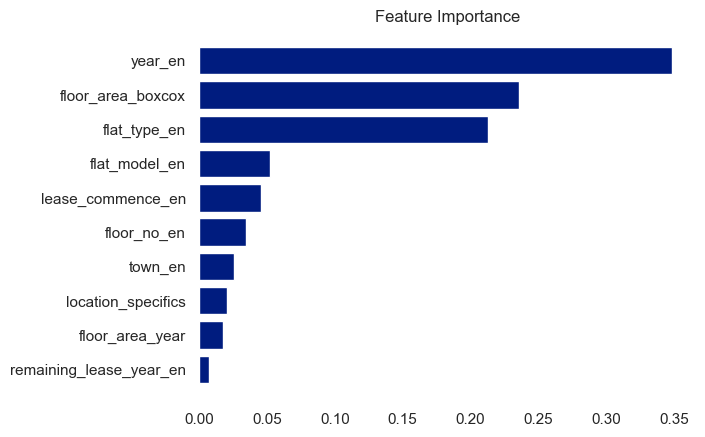

In [286]:
# Assuming XGB_model is your trained model
feature_importance = XGB_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

# Use a list comprehension to get the sorted column names
sorted_cols = [cols[i] for i in sorted_idx]
plt.barh(pos, feature_importance[sorted_idx])
plt.yticks(pos, sorted_cols)
plt.title('Feature Importance')
plt.show()

In [ ]:
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(XGB_model, max_num_features=8, ax=ax)
plt.show();

## <span style="color:Khaki;"> Model Selection:</span> 

### <p style="color:Aqua"> Evaluation: </p>

- <span Style="color:Aqua"> <b>Linear Regression and Lasso - </b></span> Both have the same R2 score and similar MSEs. They show a good fit but are slightly worse compared to other models like XGBoost and Extra Trees.

 - <span Style="color:Aqua"> <b> ElasticNet - </b></span> Shows lower performance with an R2 score of 0.81, indicating underfitting.

 - <span Style="color:Aqua"> <b> Decision Tree Regressor - </b></span>  Shows good performance with an R2 score of 0.90 but is outperformed by ensemble methods.

 - <span Style="color:Aqua"> <b> KNeighbors Regressor - </b></span> Shows very high R2 scores (0.96 for test, 0.98 for train) but has a significant difference between training and testing MSEs, indicating potential overfitting.

 - <span Style="color:Aqua"> <b> Extra Trees Regressor - </b></span> Shows excellent performance with very high R2 scores but has a significant difference between training and testing MSEs, indicating potential overfitting.

 - <span Style="color:Aqua"> <b> XGBoost Regressor - </b></span> Shows excellent performance with very high R2 scores for both test and train. It has a smaller gap between training and testing errors compared to Extra Trees, indicating less overfitting.

### <p Style="color:Aqua"> XGBoost Regressor is the best model in this case, with balanced performance and minimal overfitting.</p>
<p Style="color:Aqua"

## <span style="color:Khaki;"> Hyperparameter Tuning with Grid Searchfor XGB :</span> 

In [39]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

In [ ]:
xgb_grid = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=param_grid, scoring='r2', cv=3, verbose=3, n_jobs=1,error_score='raise')
xgb_grid.fit(x_train, y_train)

In [ ]:
print(f"XGB Best Score - {xgb_grid.best_score_}\n\nXGB Best Params - {xgb_grid.best_params_}\n\nXGB Best Estimater - {xgb_grid.best_estimator_} \n\nXGB Best Index - {xgb_grid.best_index_} ")

In [276]:
start_time = time.time()

XGB_model = XGBRegressor(learning_rate=.6, max_depth=5, n_jobs=-1, random_state=42, gamma=1, alpha=1) 

XGB_model.fit(x_train,y_train)

y_preds=XGB_model.predict(x_test)
y_preds_train = XGB_model.predict(x_train)

training_time = time.time() - start_time

print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

print(f"{color_positive}Test Mean Squared Error {reset_color} -- {mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Squared Error {reset_color} -- {mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {root_mean_squared_error(y_train,y_preds_train):.2f}\n")

print(f"{color_positive}Test R2 Score {reset_color} -- {r2_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train R2 Score {reset_color} -- {r2_score(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Mean Absolute Error {reset_color} -- {mean_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Mean Absolute Error {reset_color} -- {mean_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Median Absolute Error {reset_color} -- {median_absolute_error(y_test,y_preds):.2f}")
print(f"{color_positive}Train Median Absolute Error {reset_color} -- {median_absolute_error(y_train,y_preds_train):.2f}\n")    

print(f"{color_positive}Test Explained Var {reset_color} -- {explained_variance_score(y_test,y_preds):.2f}")
print(f"{color_positive}Train Explained Var {reset_color} -- {explained_variance_score(y_train,y_preds_train):.2f}\n")    
print('-'*50)

Training Time: 4.51 seconds

Test Mean Squared Error  -- 166.64
Train Mean Squared Error  -- 161.48

Test Root Mean Squared Error  -- 12.91
Train Root Mean Squared Error  -- 12.71

Test R2 Score  -- 0.99
Train R2 Score  -- 0.99

Test Mean Absolute Error  -- 9.64
Train Mean Absolute Error  -- 9.51

Test Median Absolute Error  -- 7.41
Train Median Absolute Error  -- 7.36

Test Explained Var  -- 0.99
Train Explained Var  -- 0.99

--------------------------------------------------


#### <span style="color:Aqua;"> I tuned few parameters manually so doing cross validations:</span> 

In [226]:
kf=KFold(n_splits=10,shuffle=True,random_state=42)
xgb_cv_score = cross_val_score(XGB_model,x_train,y_train, cv=kf)
print(f'Cross validations scores \n\n {xgb_cv_score}\n\n')
print(f'Cross validations scores mean \n\n {np.mean(xgb_cv_score)}')

Cross validations scores 

 [0.99131992 0.99166084 0.99161166 0.99156011 0.99149949 0.99135694
 0.99087731 0.99087514 0.99126604 0.99148349]


Cross validations scores mean 

 0.991351094280693


In [277]:
import os
os.makedirs('pkls', exist_ok=True)
with open(r'pkls/XGB_model.pkl', 'wb') as f:
    pickle.dump(XGB_model,f)

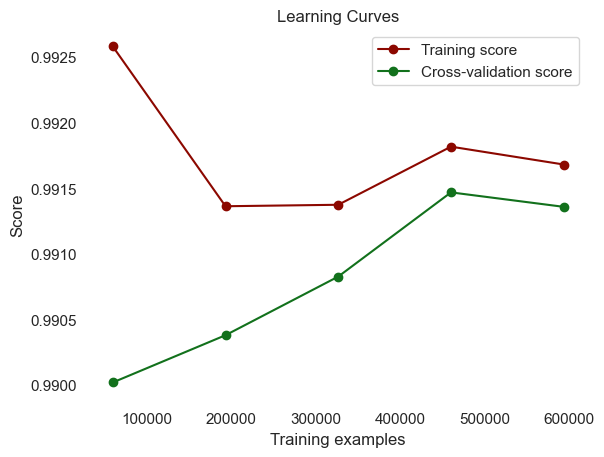

In [228]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, valid_scores = learning_curve(XGB_model, x_train, y_train, cv=5)

plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores.mean(axis=1), 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

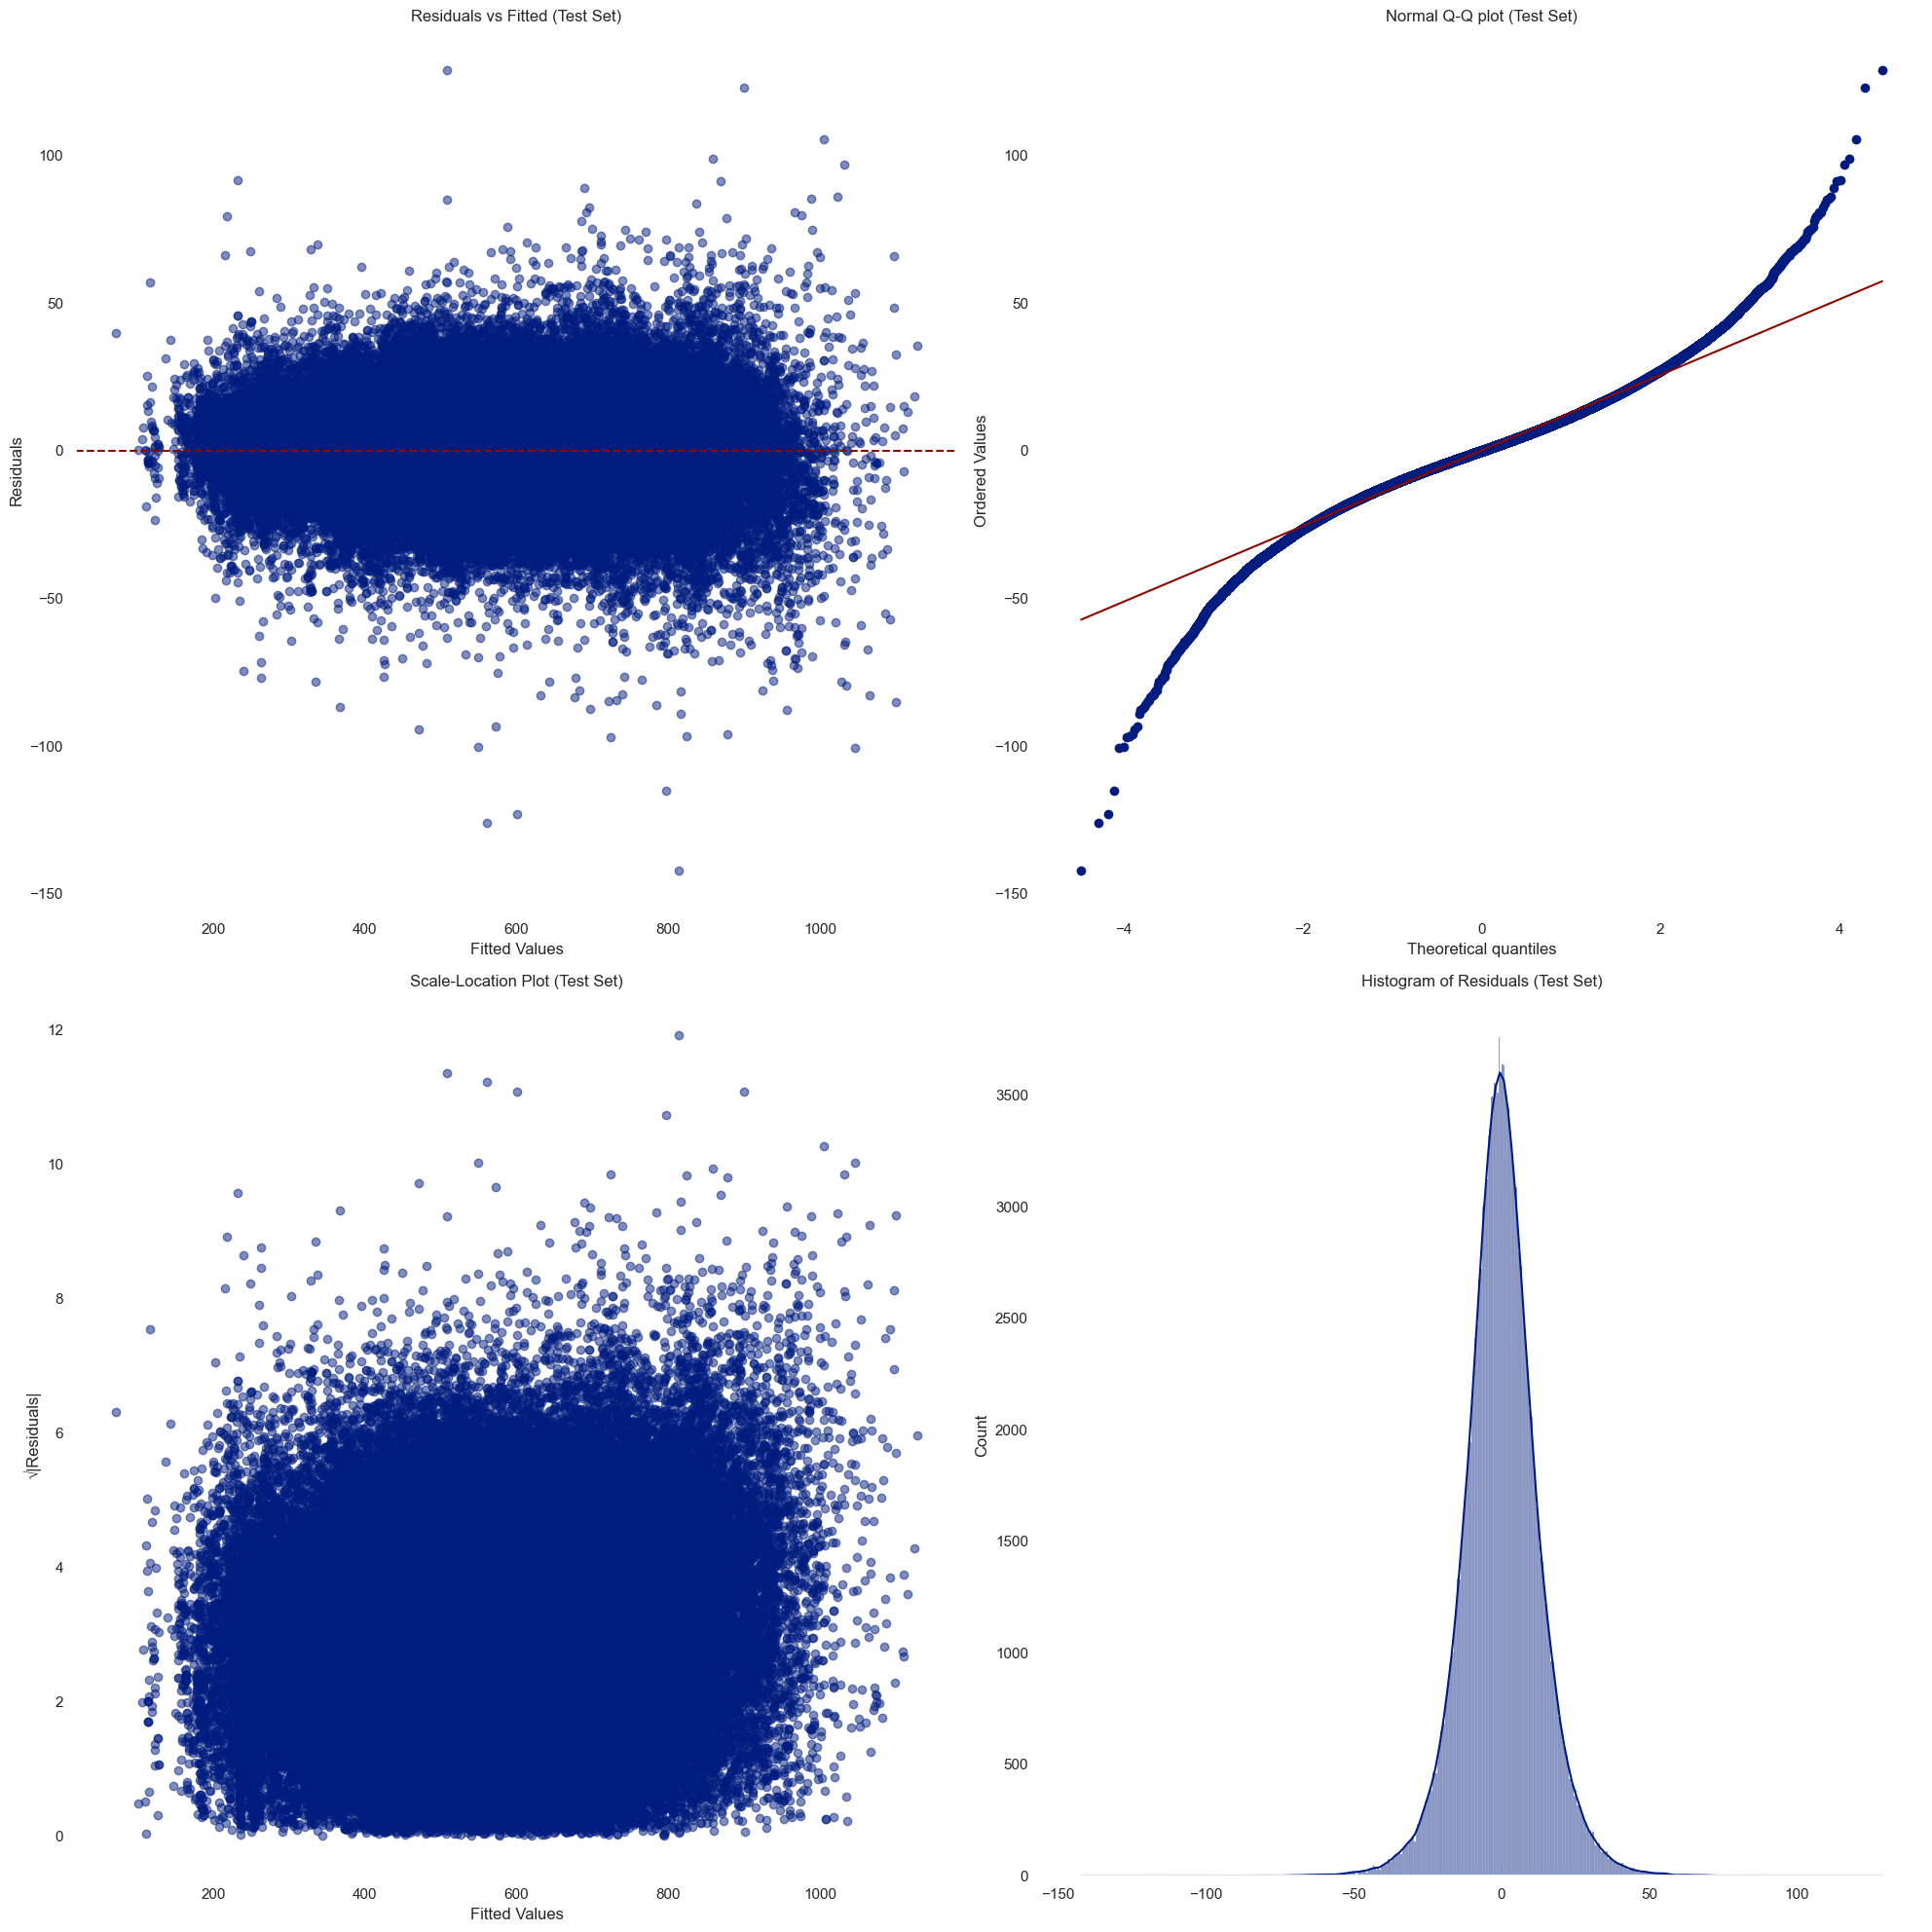

In [232]:
residuals_test = y_test - y_preds
residuals_train = y_train - y_preds_train

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# 1. Residuals vs Fitted Values (Test Set)
axes[0, 0].scatter(y_preds, residuals_test, alpha=0.5)
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (Test Set)')
axes[0, 0].axhline(y=0, color='r', linestyle='--')

# 2. Q-Q Plot (Test Set)
stats.probplot(residuals_test, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Normal Q-Q plot (Test Set)")

# 3. Scale-Location Plot (Test Set)
axes[1, 0].scatter(y_preds, np.sqrt(np.abs(residuals_test)), alpha=0.5)
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('√|Residuals|')
axes[1, 0].set_title('Scale-Location Plot (Test Set)')

# 4. Residuals Histogram (Test Set)
sns.histplot(residuals_test, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Histogram of Residuals (Test Set)')

plt.tight_layout()
plt.show()

In [247]:
index =10456

In [287]:
print(x_test[index])
print(y_test[index])

[-1.24523632  1.52833725  0.06435029 -1.06890262  0.41978676 -1.66197399
 -0.01359136 -0.64091858  0.58821145 -0.72536265]
449.77159052542174


In [288]:
user_data = x_test[index].reshape(1, -1)
print(user_data.ndim,user_data)
prediction = XGB_model.predict(user_data)
print(f"\n\n Predicted value (Box_Cox) = {prediction}, Actual value (Box_Cox) -{y_test[index]}, \n\n Differences is {y_test[index] - prediction} ")

2 [[-1.24523632  1.52833725  0.06435029 -1.06890262  0.41978676 -1.66197399
  -0.01359136 -0.64091858  0.58821145 -0.72536265]]


 Predicted value (Box_Cox) = [446.67365], Actual value (Box_Cox) -449.77159052542174, 

 Differences is [3.097931] 


In [289]:
with open(r'pkls/scale_reg.pkl', 'rb') as f:
    scale_reg = pickle.load(f)

with open(r'pkls/XGB_model.pkl', 'rb') as f:
    XGB_model = pickle.load(f)

with open(r'pkls/boxcox_lambdas.pkl', 'rb') as f:
    lambda_dict = pickle.load(f)

from scipy.special import inv_boxcox


def reverse_boxcox_transform(predicted, lambda_val):
    return inv_boxcox(predicted, lambda_val)

In [279]:
index1 = 3000

In [280]:
print(df1.iloc[index1])
print(print(df2.iloc[index1]))

month                                                3
town                                       Jurong East
flat_type                                       3 Room
floor_area_sqm                                 74.0000
flat_model                                    Improved
lease_commence_date                               1977
resale_price                                34000.0000
floors                                               3
floor_no                                             6
year                                              1990
full_address               5 Teban Gdns Rd Jurong East
price_per_sqm                                 459.4595
remaining_lease_year                                86
resale_price_boxcox                           219.1911
floor_area_boxcox                               9.8017
town_en                                             10
year_en                                              1
flat_type_en                                         3
flat_model

In [290]:
cols

['floor_area_boxcox',
 'town_en',
 'year_en',
 'flat_type_en',
 'flat_model_en',
 'lease_commence_en',
 'floor_no_en',
 'remaining_lease_year_en',
 'location_specifics',
 'floor_area_year']

In [291]:
data = df2.iloc[index1][cols].values.reshape(1,-1)
data_df = pd.DataFrame(data, columns=cols)
print(data_df)
scaled_data = scale_reg.transform(data_df)
print(scaled_data)

   floor_area_boxcox  town_en  year_en  flat_type_en  flat_model_en  \
0             9.8017  10.0000   1.0000        3.0000         7.0000   

   lease_commence_en  floor_no_en  remaining_lease_year_en  \
0             9.0000       2.0000                  11.0000   

   location_specifics  floor_area_year  
0           2191.9114        2411.1025  
[[-0.81787665 -0.46067918 -1.79831396 -1.06890262  0.41978676 -1.28766973
  -0.51045813 -0.70192945 -1.11678    -0.99810728]]


In [292]:
prediction = XGB_model.predict(scaled_data)
print(f"Predicted value (Box_Cox) {prediction}")
transformed_predict=reverse_boxcox_transform(prediction, lambda_dict['resale_price_lambda'])
print(f"Predicted value (Inverse Box_Cox) {transformed_predict}")

Predicted value (Box_Cox) [214.17111]
Predicted value (Inverse Box_Cox) [32269.146]


In [293]:
actuals = int(df1.iloc[index1][['resale_price']].values[0])
actuals

34000

In [294]:
print(f"Predicted value (Inverse Box_Cox) {transformed_predict}, Actual value (without Box_Cox Transformation) -{actuals}, \n\n Differences is {actuals - transformed_predict}")

Predicted value (Inverse Box_Cox) [32269.146], Actual value (without Box_Cox Transformation) -34000, 

 Differences is [1730.8535]
